In [1]:
#
import sys
import os
sys.path.append('/home/mt/Dropbox/xas-database/code')

import t4iss
from t4iss.core import *
from copy import deepcopy

import numpy as np
import pickle
from glob import glob
from pymatgen import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.chemenv.coordination_environments.coordination_geometry_finder import LocalGeometryFinder
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies import MultiWeightsChemenvStrategy
from pymatgen.analysis.chemenv.coordination_environments.structure_environments import LightStructureEnvironments
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from sklearn.cluster import DBSCAN
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr, spearmanr

lgf = LocalGeometryFinder()
strategy = MultiWeightsChemenvStrategy.stats_article_weights_parameters()

def getKey(item): return item[2]


from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr,spearmanr,kendalltau 
from scipy.optimize import nnls


Imported t4iss with defaults:

- t4iss_xanes_data : /home/mt/.t4iss/xanes_data
- t4iss_scratch : /home/mt/.t4iss/scratch
- mcr_path : /home/mt/Dropbox/xas-database/code/t4iss/mcr
- scripts_path : /home/mt/Dropbox/xas-database/code/t4iss/scripts
- octave_path : /usr/bin/octave
- matlab_path : None

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346–8360,
DOI: 10.1021/acs.chemmater.7b02766



In [2]:
# optimizer 
def optimizer(target,basis_set,rshifts,emax_opt=50,prefix=None,suffix=None,verbose=False,normalization='max'):

    scores_mae = []
    scores_mse = []
    scores_pea = []
    scores_spm = []

    fits = []
    outs = []
    rshifts_all = []
    shifts = []

    target[0].transform(irange=[0,emax_opt],x0shift=True,y0shift=True,normalize=normalization)
    
    for rshift in rshifts[0]:

        if verbose:
            print('Doing rshift: %3.2f'%rshift)
        
        ishifts = []
        
        for i in range(4):
            if basis_set[i][3][2] < 1 or basis_set[i][2] == 0: ishifts.append([rshift]); 
            else: ishifts.append(np.linspace(rshift+basis_set[i][3][0],rshift+basis_set[i][3][1],num=basis_set[i][3][2]))
           

        for s1 in ishifts[0]:
            for s2 in ishifts[1]:      
                for s3 in ishifts[2]:
                    for s4 in ishifts[3]:
                        basis_set[0][0].transform(irange=[0,emax_opt],x0shift=True,y0shift=True,normalize=normalization,xshift=s1)
                        basis_set[1][0].transform(irange=[0,emax_opt],x0shift=True,y0shift=True,normalize=normalization,xshift=s2)
                        basis_set[2][0].transform(irange=[0,emax_opt],x0shift=True,y0shift=True,normalize=normalization,xshift=s3)
                        basis_set[3][0].transform(irange=[0,emax_opt],x0shift=True,y0shift=True,normalize=normalization,xshift=s4)

                        A = np.row_stack((basis_set[0][0].I*basis_set[0][2],
                                          basis_set[1][0].I*basis_set[1][2],
                                          basis_set[2][0].I*basis_set[2][2],
                                          basis_set[3][0].I*basis_set[3][2]))
                        b = target[0].I
                        out = nnls(A.T,b)

                        fit = np.dot(out[0],A); fit = fit / max(fit)

                        score_mae = mean_squared_error(target[0].I,fit)   
                        score_mse = mean_absolute_error(target[0].I,fit) 
                        score_pea = pearsonr(target[0].I,fit)[0]
                        score_spm = spearmanr(target[0].I,fit)[0]

                        scores_mae.append(score_mae); scores_mse.append(score_mse); scores_pea.append(score_pea); scores_spm.append(score_spm)            
                        shifts.append([s1,s2,s3,s4])  
                        rshifts_all.append(rshift)


    imin_mae = np.argmin(scores_mae); shifts_mae = shifts[imin_mae]
    imin_mse = np.argmin(scores_mse); shifts_mse = shifts[imin_mse]
    imax_pea = np.argmax(scores_pea); shifts_pea = shifts[imax_pea]
    imax_spm = np.argmax(scores_spm); shifts_spm = shifts[imax_spm]
    
    print('optimum rshift from mae is %3.2f'%rshifts_all[imin_mae])
    print('optimum rshift from mse is %3.2f'%rshifts_all[imin_mse])
    print('optimum rshift from pea is %3.2f'%rshifts_all[imax_pea])
    print('optimum rshift from spm is %3.2f'%rshifts_all[imax_spm])    
    
    if prefix is None:
        prefix='optim_14'
    if suffix is None:
        suffix=''
    pname = prefix+'.'+suffix+'.pkl'  
 
    pickle.dump([target,basis_set,emax_opt,shifts_mae,shifts_mse,shifts_pea,shifts_spm,normalization],open(pname,'wb'))
    
    return

In [24]:
# plotter 
def plotter(prefix,suffix,normalization_plt='max',emax_plt=50,normalize_fit=True,pdfexport=False):
    
    fits = []
    
    pname = prefix+'.'+suffix+'.pkl'
    [target,basis_set,emax_opt,shifts_mae,shifts_mse,shifts_pea,shifts_spm,normalization] = pickle.load(open(pname,'rb'))
    

    def funct(ax,shifts,metric,titlestr):
        # get out from optimization    
        for i in range(len(basis_set)):
            basis_set[i][0].transform(irange=[0,emax_opt],x0shift=True,y0shift=True,normalize=normalization,xshift=shifts[i])
        target[0].transform(irange=[0,emax_opt],x0shift=True,y0shift=True,normalize=normalization,std=False,xshift=0)
        A = np.row_stack((basis_set[0][0].I*basis_set[0][2],basis_set[1][0].I*basis_set[1][2],basis_set[2][0].I*basis_set[2][2],basis_set[3][0].I*basis_set[3][2]))
        b = target[0].I
        out = nnls(A.T,b)

        

        # transform spectra for plot
        target[0].transform(irange=[0,emax_plt],x0shift=True,y0shift=True,normalize=normalization_plt,std=False,xshift=0)
        for i in range(4):
            basis_set[i][0].transform(irange=[0,emax_plt],x0shift=True,y0shift=True,normalize=normalization_plt,xshift=shifts[i])
        A = np.row_stack((basis_set[0][0].I*basis_set[0][2],basis_set[1][0].I*basis_set[1][2],basis_set[2][0].I*basis_set[2][2],basis_set[3][0].I*basis_set[3][2]))
        fit = np.dot(out[0],A)
        
        if metric == pearsonr or metric == spearmanr:
            score = metric(target[0].I,fit)[0]
        else:
            score = metric(target[0].I,fit)


        if normalize_fit:
            fit = fit / max(fit) 
    #     fit_new = mXANES(data=[target[0].E,fit])
    #     fit_new.transform(irange=[0,emax_plt+10])
    #     fit_broad = mXANES(data=[fit_new.E,fit_new.I])
    #     fit_broad.broaden0(lvl=[0.1,0.1,fit_broad.Eonset+15])
    #     fit_broad.transform(irange=[0,emax_plt],x0shift=True,y0shift=True,normalize='max')

        ax.plot(target[0].E+4963,0.1+target[0].I, '-k', lw=2, alpha=0.8, label=target[1])  
        ax.plot(target[0].E+4963,0.1+fit, '--r', lw=2, alpha=0.8, label='fit');
        fits.append([target[0].E,fit])
        
    #     ax.plot(fit_broad.E,0.1+fit_broad.I, ':b', lw=2, alpha=0.8, label='fit_broad');  

        yshift = 0
        for i in range(len(basis_set)):
            if out[0][i]/sum(out[0]) < 0.01:
                ax.plot(target[0].E+4963,yshift+0.3*basis_set[i][0].I, lw=4, alpha=(out[0][i]/sum(out[0])), label=' ');
                yshift -= 0.1
            else:
                ax.plot(target[0].E+4963,yshift+0.3*basis_set[i][0].I, lw=4, alpha=(out[0][i]/sum(out[0])), label='(%3.2f) '%(out[0][i]/sum(out[0]))+basis_set[i][1]);            
                yshift -= 0.1

        ax.plot([emax_opt+4963,emax_opt+4963],[-0.72,1.42],':k',lw=1)

        ax.legend(loc='lower right',fontsize=12,ncol=1); ax.set_ylim([-0.51,1.22]); ax.set_yticks([]); 
        ax.set_title('metric='+titlestr+' (%7.4f)'%score,fontsize=20)

        
    fig = plt.figure(figsize=(20,10))

    funct(ax=fig.add_subplot('141'),shifts=shifts_mae,metric=mean_absolute_error,titlestr='MAE')
    funct(ax=fig.add_subplot('142'),shifts=shifts_mse,metric=mean_squared_error,titlestr='MSE')
    funct(ax=fig.add_subplot('143'),shifts=shifts_pea,metric=pearsonr,titlestr='Pearson')    
    funct(ax=fig.add_subplot('144'),shifts=shifts_spm,metric=spearmanr,titlestr='Spearman')    
    
    plt.tight_layout()    
    if pdfexport:
        pdfname = prefix+'.'+suffix+'.pdf'
        plt.savefig(pdfname,dpi=600)
        
    return fits

In [4]:
# collect spectra
spectra = []

E,I = np.loadtxt('embedded.dat', unpack=True, comments='#', skiprows=0); E = E/10
spectra.append(mXANES(data=[E,I],Eonset=4963,xanesid='Embedded'))
spectra[0].transform(irange=[0,55],x0shift=True,y0shift=True,normalize='tail')

E,I = np.loadtxt('TiO.dat', unpack=True, comments='#', skiprows=0); E = E/10
spectra.append(mXANES(data=[E,I],Eonset=4963,xanesid='TiO'))
spectra[1].transform(irange=[0,55],x0shift=True,y0shift=True,normalize='tail')

E,I = np.loadtxt('Y2TiO5.dat', unpack=True, comments='#', skiprows=0); E = E/10
spectra.append(mXANES(data=[E,I],Eonset=4963,xanesid='Y2TiO5'))
spectra[2].transform(irange=[0,55],x0shift=True,y0shift=True,normalize='tail')

E,I = np.loadtxt('Y2Ti2O7.dat', unpack=True, comments='#', skiprows=0); E = E/10
spectra.append(mXANES(data=[E,I],Eonset=4963,xanesid='Y2Ti2O7'))
spectra[3].transform(irange=[0,55],x0shift=True,y0shift=True,normalize='tail')

E,I = np.loadtxt('extracted.dat', unpack=True, comments='#', skiprows=0); E = E/10
spectra.append(mXANES(data=[E,I],Eonset=4963,xanesid='Extracted'))
spectra[4].transform(irange=[0,55],x0shift=True,y0shift=True,normalize='tail')


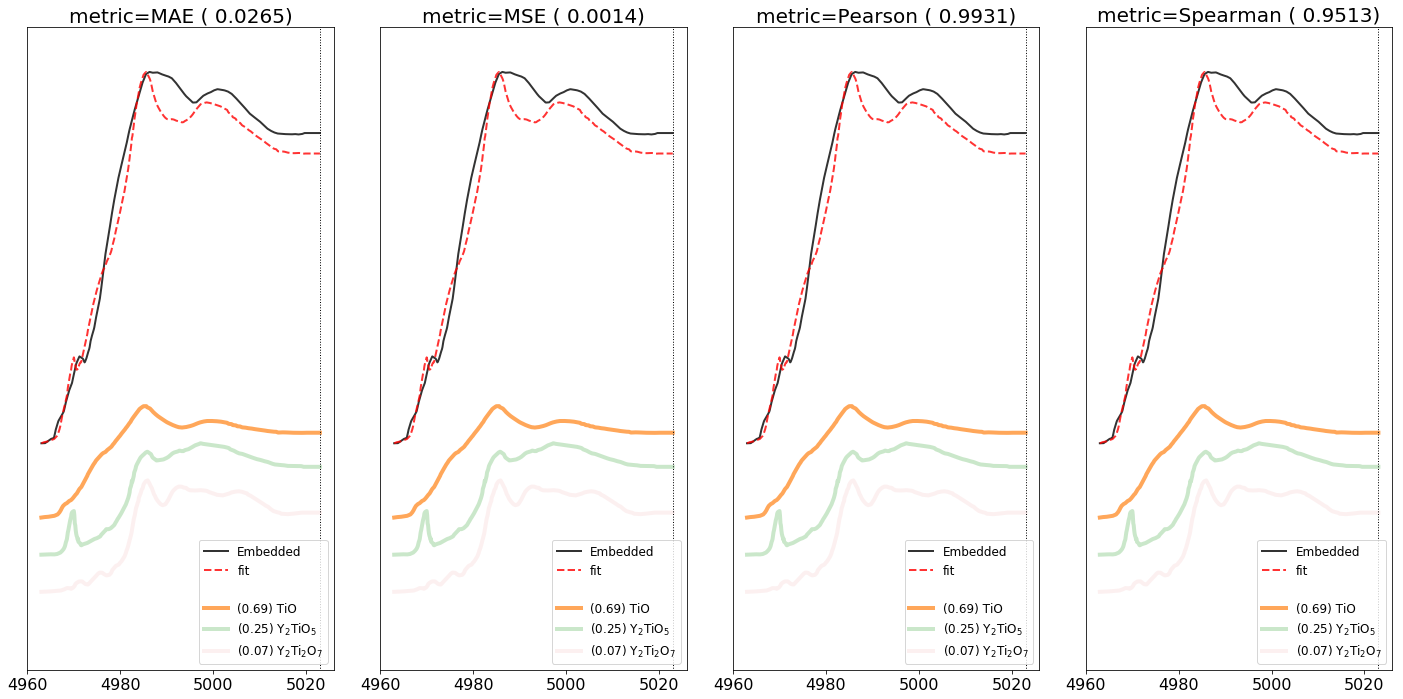

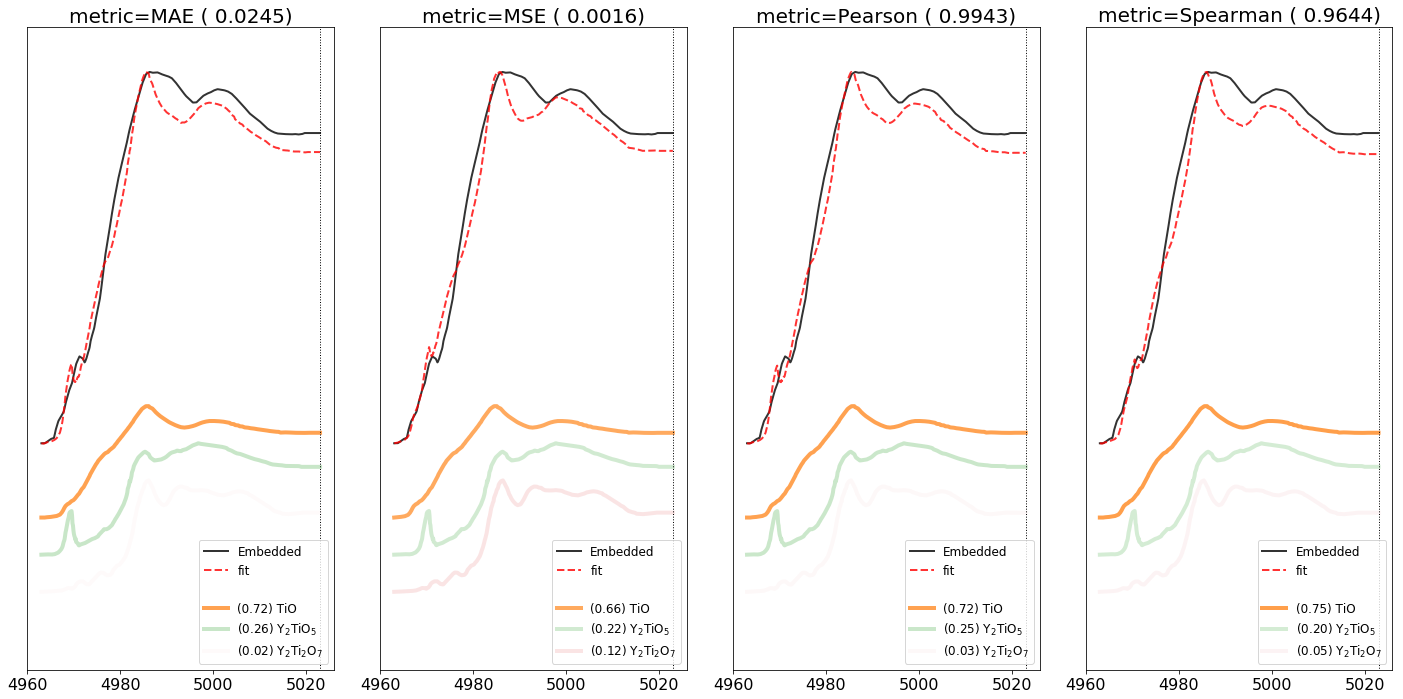

In [28]:
#
emax=60

prefix='embedded'
suffix='fixed-emax.%d'%emax

basis_set=[[spectra[4],'Extracted',0,[0,0,1]],
           [spectra[1],'TiO',1,     [0,0,1]],
           [spectra[2],'Y$_2$TiO$_5$',1,  [0,0,1]],     
           [spectra[3],'Y$_2$Ti$_2$O$_7$',1, [0,0,1]]]
target=[spectra[0],'Embedded']
rshifts = [[0]]
# optimizer(target,basis_set,rshifts,emax,prefix,suffix,verbose=True);
fits = plotter(prefix,suffix,emax_plt=60,pdfexport=True)


prefix='embedded'
suffix='variable-emax.%d'%emax

basis_set=[[spectra[4],'Extracted',0,[-0.5,0.5,21]],
           [spectra[1],'TiO',1,     [-0.5,0.5,21]],
           [spectra[2],'Y$_2$TiO$_5$',1,  [-0.5,0.5,21]],     
           [spectra[3],'Y$_2$Ti$_2$O$_7$',1, [-0.5,0.5,21]]]
target=[spectra[0],'Embedded']
rshifts = [[0]]
# optimizer(target,basis_set,rshifts,emax,prefix,suffix,verbose=True);
fits_embedded = plotter(prefix,suffix,emax_plt=60,pdfexport=True);

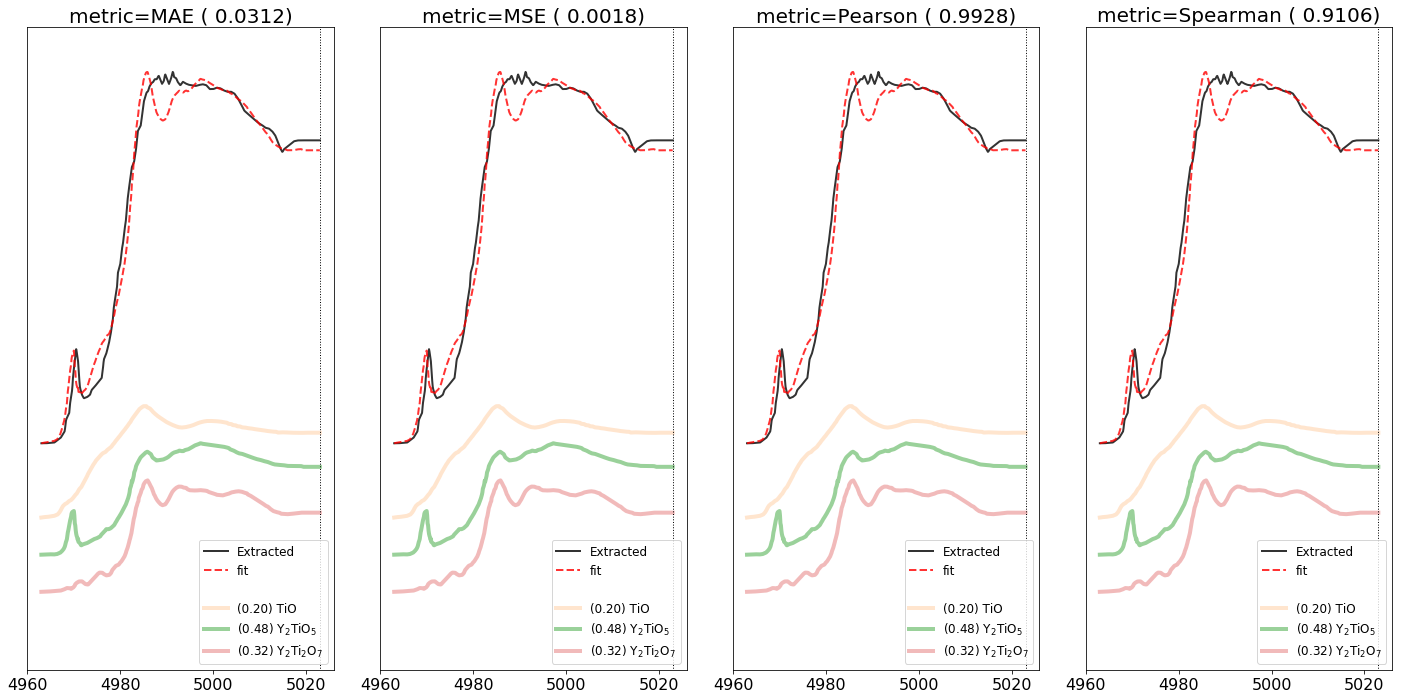

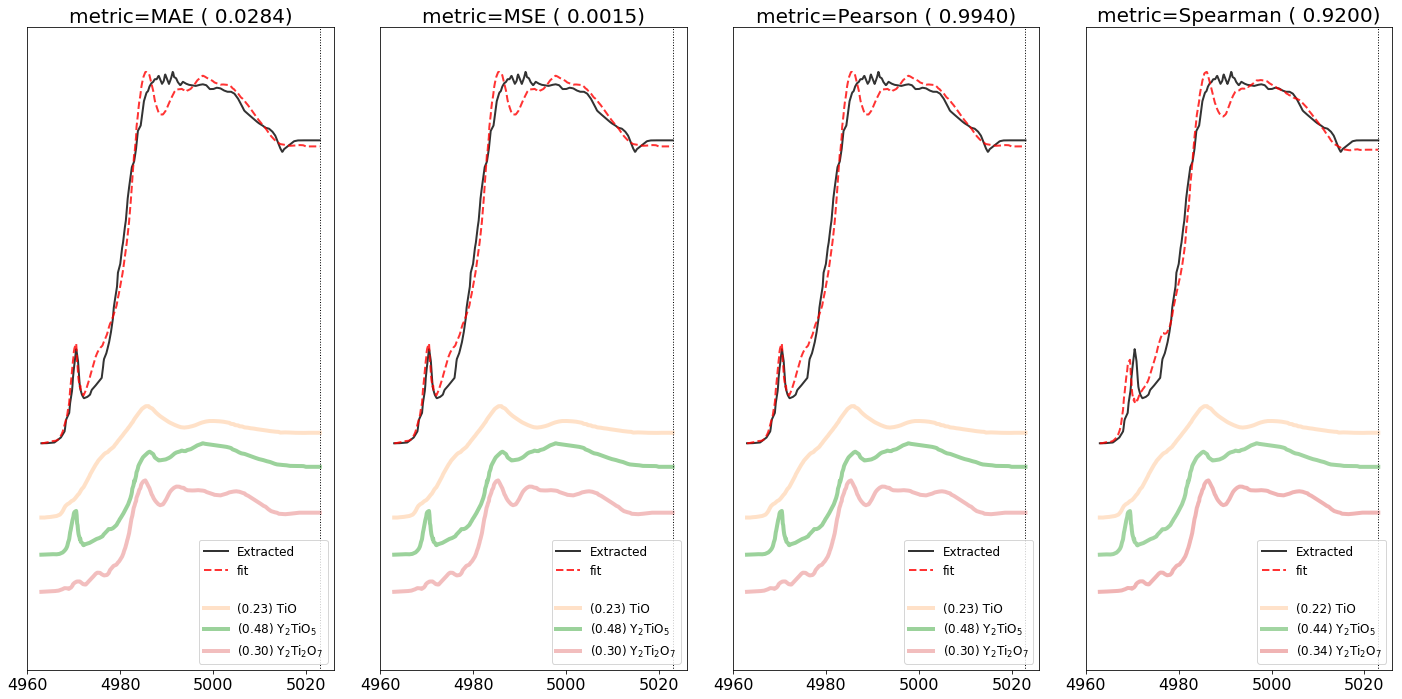

In [27]:
#
emax=60

prefix='extracted'
suffix='fixed-emax.%d'%emax

basis_set=[[spectra[0],'Embedded',        0,[0,0,1]],
           [spectra[1],'TiO',             1,[0,0,1]],
           [spectra[2],'Y$_2$TiO$_5$'    ,1,[0,0,1]],     
           [spectra[3],'Y$_2$Ti$_2$O$_7$',1,[0,0,1]]]
target=[spectra[4],'Extracted']
rshifts = [[0]]
# optimizer(target,basis_set,rshifts,emax,prefix,suffix,verbose=True);
fits = plotter(prefix,suffix,emax_plt=60,pdfexport=True);

prefix='extracted'
suffix='variable-emax.%d'%emax

basis_set=[[spectra[0],'Embedded',        0,[-0.5,0.5,21]],
           [spectra[1],'TiO',             1,[-0.5,0.5,21]],
           [spectra[2],'Y$_2$TiO$_5$'    ,1,[-0.5,0.5,21]],     
           [spectra[3],'Y$_2$Ti$_2$O$_7$',1,[-0.5,0.5,21]]]
target=[spectra[4],'Extracted']
rshifts = [[0]]
# optimizer(target,basis_set,rshifts,emax,prefix,suffix,verbose=True);
fits_extracted = plotter(prefix,suffix,emax_plt=60,pdfexport=True);

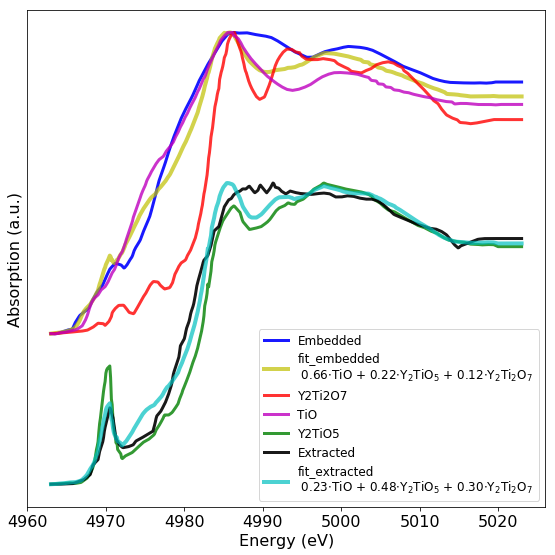

In [40]:

# plot all spectra
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot('111')

ax.plot(4963+spectra[0].E, 0.5+spectra[0].I, 'b', lw=3, alpha=0.9, label=spectra[0].xanesid) 
ax.plot(4963+fits_embedded[1][0],   0.5+fits_embedded[1][1], 'y-', lw=4, alpha=0.7, label='fit_embedded\n 0.66$\cdot$TiO + 0.22$\cdot$Y$_2$TiO$_5$ + 0.12$\cdot$Y$_2$Ti$_2$O$_7$ ')
ax.plot(4963+spectra[3].E, 0.5+spectra[3].I, 'r', lw=3, alpha=0.8, label=spectra[3].xanesid) 
ax.plot(4963+spectra[1].E, 0.5+spectra[1].I, 'm', lw=3, alpha=0.8, label=spectra[1].xanesid)
ax.plot(4963+spectra[2].E, 0.0+spectra[2].I, 'g', lw=3, alpha=0.8, label=spectra[2].xanesid)
ax.plot(4963+spectra[4].E, 0.0+spectra[4].I, 'k', lw=3, alpha=0.9, label=spectra[4].xanesid) 
ax.plot(4963+fits_extracted[1][0],   0.0+fits_extracted[1][1], 'c-', lw=4, alpha=0.7, label='fit_extracted\n 0.23$\cdot$TiO + 0.48$\cdot$Y$_2$TiO$_5$ + 0.30$\cdot$Y$_2$Ti$_2$O$_7$ ')


ax.legend(loc='best',fontsize=12,ncol=1)
ax.set_yticks(());
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Absorption (a.u.)')


plt.tight_layout()

plt.savefig('plot.pdf',dpi=600)